In [16]:
import torch
import functools as ft

In [17]:
class CreationAnnihilation:
    def __init__(self, max_occs: int):
        d = torch.arange(1, max_occs + 1)
        self.c = torch.diag(d, diagonal=-1)
        self.a = torch.diag(d, diagonal=1)

In [18]:
def circular_shift(lst, shift_by):
    if not lst:
        return lst
    shift_by %= len(lst)  # Handle shifts greater than the list length
    return lst[-shift_by:] + lst[:-shift_by]

In [19]:
def exact_hopping(t, n_sites):
    """
    Manual creation of a hopping Hamiltonian as a sum of tensor product'd
    creation and annihilation operators.

    Local number basis: dimension 2

    Occupation basis: dimension 2 * 2 * n_sites
    """

    I_occ_to_spin = torch.eye(2)
    I_spin_to_site = torch.eye(4)

    def reference_list(op: torch.Tensor, I: torch.Tensor, pos: int, num: int):
        """
        Produces a list to tensor-product across to bring an operator from a local
        vector space up to a global vector space.
        """

        l = [I] * num
        l[pos] = op
        return l

    ops = CreationAnnihilation(1)

    @ft.lru_cache(maxsize=None)
    def up_a_space(op: torch.Tensor, I: torch.Tensor, pos: int, num: int):
        r_list = reference_list(op, I, pos, num)
        r_list = circular_shift(r_list, pos)
        res = ft.reduce(torch.kron, r_list)
        return res

    # TODO: be sure cache keys don't involve deep comparisons of tensors

    @ft.lru_cache(maxsize=None)
    def spin_creation(spin_i: int):
        return up_a_space(ops.c, I_occ_to_spin, pos=spin_i, num=2)

    @ft.lru_cache(maxsize=None)
    def spin_annihilation(spin_i: int):
        return up_a_space(ops.a, I_occ_to_spin, pos=spin_i, num=2)

    def hopping_contribution(site_i: int, sp_i: int, site_j: int, sp_j: int):
        """
        The operator describing the hopping contribution between two spins.
        """
        c = spin_creation(sp_i)
        a = spin_annihilation(sp_j)
        c = up_a_space(c, I_spin_to_site, pos=site_i, num=n_sites)
        a = up_a_space(a, I_spin_to_site, pos=site_j, num=n_sites)
        contribution = c @ a
        return contribution

    def site_site_interaction(site_i: int, sp_i: int, site_j: int, sp_j: int):
        i_to_j = hopping_contribution(site_i, sp_i, site_j, sp_j)
        j_to_i = i_to_j.conj().T
        return i_to_j + j_to_i

    def add_interaction_contribution(
        site_i: int,
        sp_i: int,
        site_j: int,
        sp_j: int,
        t: int,
        buf_ref: torch.Tensor,
    ):
        interactions = site_site_interaction(site_i, sp_i, site_j, sp_j)
        buf_ref += -t * interactions

    def interactions():
        for i in range(n_sites):
            for j in range(2):
                print(f"i: {i}, j: {j}")
                yield (i, j, (i + 1) % n_sites, j)

    buf_ref = torch.zeros(
        (2 ** (2 * n_sites), 2 ** (2 * n_sites)),
        dtype=torch.float32,
    )
    for site_i, sp_i, site_j, sp_j in interactions():
        add_interaction_contribution(site_i, sp_i, site_j, sp_j, t, buf_ref)

    return buf_ref



In [20]:
exact_hopping(1, 3)

i: 0, j: 0
i: 0, j: 1
i: 1, j: 0
i: 1, j: 1
i: 2, j: 0
i: 2, j: 1


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
exact_hopping(1, 3).shape   

i: 0, j: 0
i: 0, j: 1
i: 1, j: 0
i: 1, j: 1
i: 2, j: 0
i: 2, j: 1


torch.Size([64, 64])

i: 0, j: 0
i: 0, j: 1
i: 1, j: 0
i: 1, j: 1
i: 2, j: 0
i: 2, j: 1


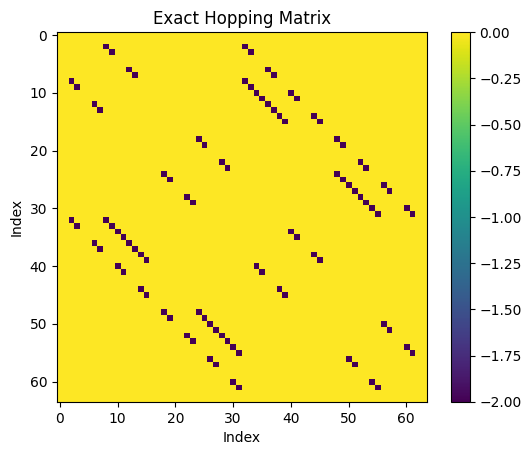

In [22]:
hopping = exact_hopping(1, 3)

import matplotlib.pyplot as plt

plt.imshow(hopping.numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Exact Hopping Matrix")
plt.xlabel("Index")
plt.ylabel("Index")
plt.show()